In [1]:
import importlib
import micasense.capture
import cv2
import os, glob
import json
import pickle #This library will maintain the format as well
from osgeo import gdal,osr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image as Image
import datetime
from math import ceil
from tqdm import tqdm
import re
import glob
from PIL import Image

import algorithms.flight_attributes
import algorithms.validate_algorithm
import algorithms.select_GPS as SelectGPS
import algorithms.georeferencing

importlib.reload(algorithms.flight_attributes)
importlib.reload(algorithms.georeferencing)

import algorithms.flight_attributes as FlightAttributes
import algorithms.georeferencing as georeferencing

## Import data that has been processed by the Micasense's image processing library

In [2]:
imagePath = r"D:\EPMC_flight\pandanRes\00angle_15H_50overlap"
rawImagePath = os.path.join(imagePath,'RawImg') # We created a new folder called RawImg to store all the raw images here
flightAttributesPath = os.path.join(imagePath,'flight_attributes','flight_attributes.csv')
if os.path.exists(flightAttributesPath):
    log = pd.read_csv(flightAttributesPath)
log.head()

,timestamp,latitude,longitude,altitude,image_name,capture_id,dls-yaw,dls-pitch,dls-roll,irr-475,irr-560,irr-668,irr-842,irr-717,irr-444,irr-531,irr-650,irr-705,irr-740
0,2023-09-20 02:37:46.734108+00:00,1.318984,103.736576,30.643,IMG_0000_1.tif,iRMg5hgGW1CUYi1x0TlZ,0.635662,-0.207969,-0.047398,0.744841,0.663156,0.547643,0.342493,0.428046,0.670643,0.687768,0.544391,0.483355,0.445280
1,2023-09-20 02:38:25.652070+00:00,1.318969,103.736552,31.828,IMG_0001_1.tif,ws9iE0ctR0GdjP9XYeKY,1.768777,-0.081365,-0.034487,1.422521,1.305924,1.134642,0.701718,0.873402,1.247496,1.338475,1.114349,0.995491,0.917994
2,2023-09-20 02:40:02.646889+00:00,1.318935,103.736667,31.825,IMG_0002_1.tif,o34Xx90IfaznKeSuG8Bq,1.807706,-0.066323,-0.019898,0.403826,0.350253,0.274099,0.171907,0.214341,0.371606,0.366940,0.274736,0.241525,0.222003
3,2023-09-20 02:40:27.129650+00:00,1.318957,103.736711,43.093,IMG_0003_1.tif,9uaW8y0N0EE0vgF9zbKj,0.603067,-0.147849,0.018589,0.394172,0.341704,0.268347,0.168132,0.209751,0.362208,0.357995,0.268675,0.236576,0.217652
4,2023-09-20 02:40:28.687747+00:00,1.318989,103.736740,43.126,IMG_0004_1.tif,573tCs56BPBA8nQJo06y,0.632837,-0.131004,0.014908,0.393962,0.341402,0.268274,0.168016,0.209701,0.361889,0.357701,0.268546,0.236570,0.217697


## View flight altitude

In [3]:
# helper function that is only relevant to my file naming. I named my imagePath folder as the UAV height e.g. ...15H...
# this step is (optional)
height_dict = FlightAttributes.get_heights(imagePath,log)
height_dict

offset height: 26m


{'measuredHeight': 41.295,
 'actualHeight': 15,
 'height_max': 52.609,
 'height_min': 23.956,
 'DEM_offset_height': 26}

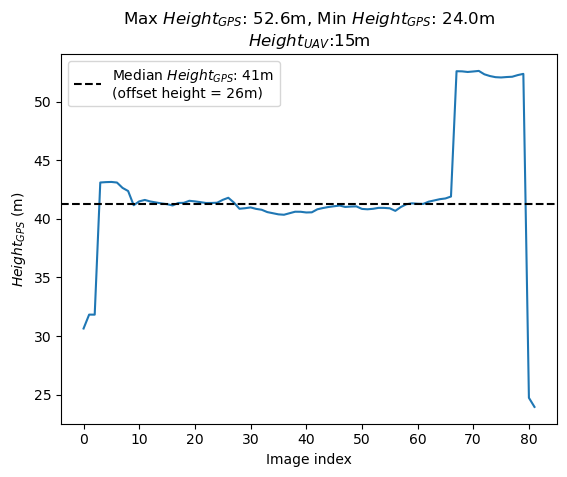

In [4]:
plt.figure()
plt.plot(log.index.to_list(),log['altitude'])
height_max = height_dict['height_max']
height_min = height_dict['height_min']
measuredHeight = height_dict['measuredHeight']
actualHeight = height_dict['actualHeight']
DEM_offset_height = height_dict['DEM_offset_height']
plt.axhline(y=measuredHeight, ls='--',c='k',label=r'Median $Height_{GPS}$:' f" {int(measuredHeight)}m\n(offset height = {DEM_offset_height}m)")
plt.title(r'Max $Height_{GPS}$:' + f' {height_max:.1f}m, ' + r'Min $Height_{GPS}$: ' + f'{height_min:.1f}m\n' + r'$Height_{UAV}$:' +f'{actualHeight}m')
plt.ylabel(r'$Height_{GPS}$ (m)')
plt.xlabel('Image index')
plt.legend()
# save fig
parentDir = os.path.join(os.path.dirname(imagePath),"images")
os.mkdir(parentDir) if not os.path.exists(parentDir) else None
fname = os.path.join(parentDir,f'height_timeseries.png')
plt.savefig(fname)

plt.show()

## Detect points/Import GPS points

[10, 15, 19, 25, 29, 35, 39, 45, 49, 55, 59, 65]


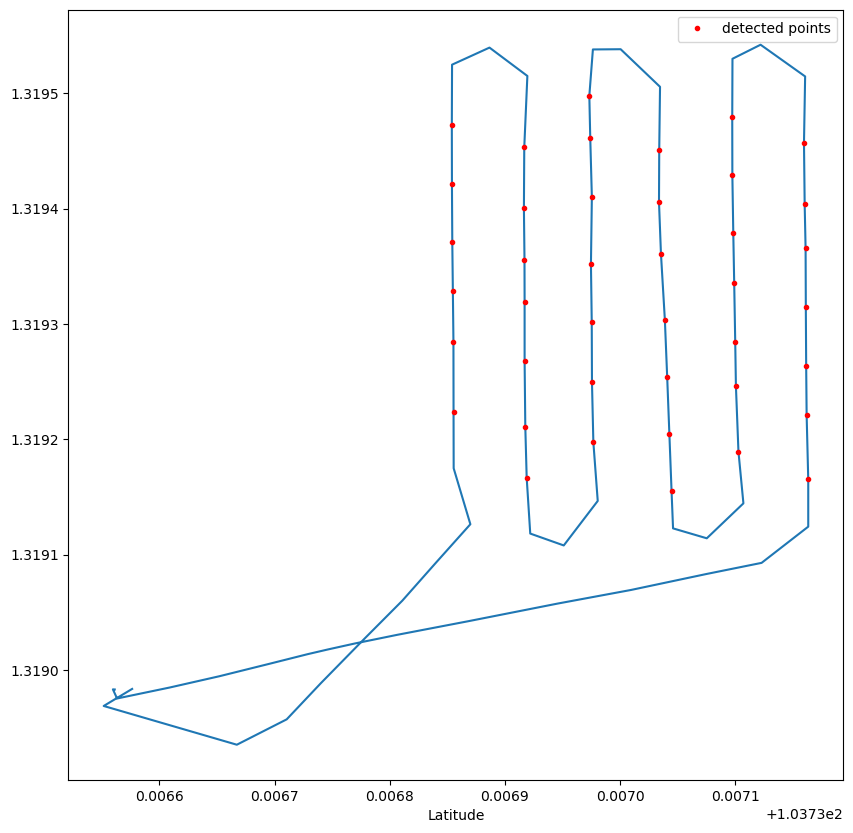

[10, 11, 12, 13, 14, 15, 19, 20, 21, 22, 23, 24, 25, 29, 30, 31, 32, 33, 34, 35, 39, 40, 41, 42, 43, 44, 45, 49, 50, 51, 52, 53, 54, 55, 59, 60, 61, 62, 63, 64, 65]


In [5]:
# import GPS points
ls_idx = SelectGPS.readSelectedGPS(rawImagePath)
# print(ls_idx)
# plot selected GPS points
DL = SelectGPS.DetectLines(log, n = 3, thresh=0.99, plot=True)
flight_points = DL.get_points(flight_points = ls_idx)
print(flight_points)

# No correction

C:\Users\PAKHUIYING\AppData\Local\Temp\ipykernel_34436\629964051.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cropped['flight_angle'] = -df_cropped.loc[:,'dls-yaw']/np.pi*180


shape of canvas(4381, 4386, 3)


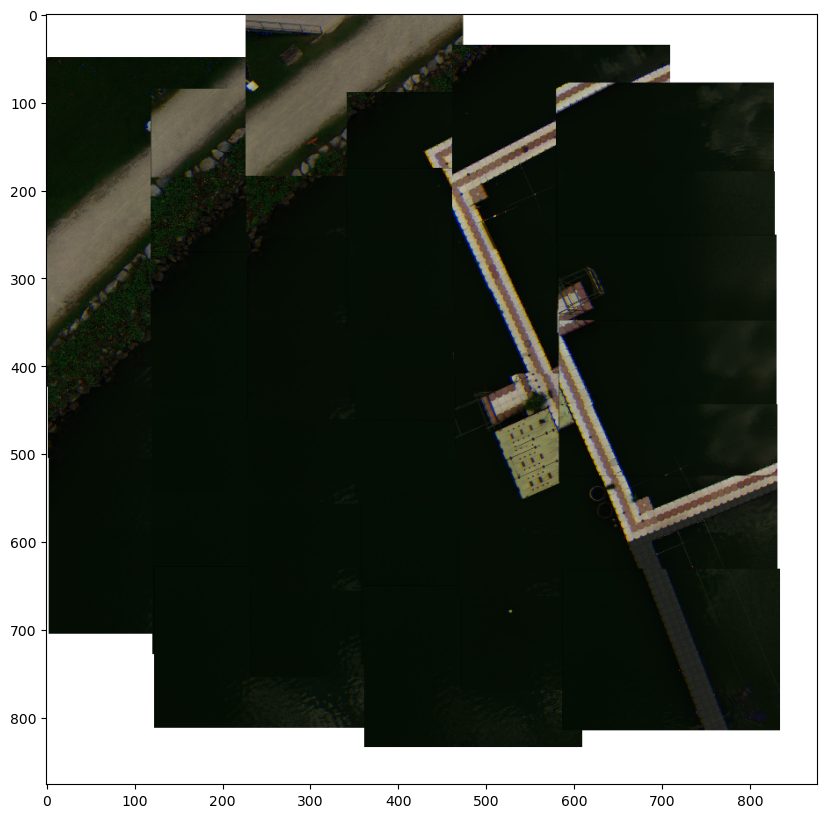

In [15]:
DEM_offset_height = 23
df_cropped = log.iloc[flight_points,:]
df_cropped['flight_angle'] = -df_cropped.loc[:,'dls-yaw']/np.pi*180
fp_list = [os.path.join(imagePath,'thumbnails',f'{os.path.splitext(fn)[0]}.jpg') for fn in df_cropped['image_name'].tolist()]
if all([os.path.exists(fp) for fp in fp_list]):
    PG = FlightAttributes.PlotGeoreference(df_cropped,fp_list,DEM_offset_height = DEM_offset_height)
    im_display = PG.plot_georeference(reduction_factor=5,plot=True)

In [18]:
for image_index, rows in df_cropped.iterrows():
    lat = rows['latitude']
    lon = rows['longitude']
    alt = rows['altitude'] - DEM_offset_height
    pitch = rows['dls-pitch']
    roll = rows['dls-roll']
    yaw = rows['dls-yaw']
    image_name = rows['image_name']
    print(f'[{image_index}] {image_name}')
    flight_angle = rows['flight_angle']
    georeferencing.directGeoreferencing_gdal(imagePath,image_name,lat,lon,alt,flight_angle,
                                             dirname=f"noCorrection_alt{int(measuredHeight - DEM_offset_height)}")

[10] IMG_0010_1.tif


c:\Users\PAKHUIYING\anaconda3\envs\micasenseGeoreferencing\lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


[11] IMG_0011_1.tif
[12] IMG_0012_1.tif
[13] IMG_0013_1.tif
[14] IMG_0014_1.tif
[15] IMG_0015_1.tif
[19] IMG_0019_1.tif
[20] IMG_0020_1.tif
[21] IMG_0021_1.tif
[22] IMG_0022_1.tif
[23] IMG_0023_1.tif
[24] IMG_0024_1.tif
[25] IMG_0025_1.tif
[29] IMG_0029_1.tif
[30] IMG_0030_1.tif
[31] IMG_0031_1.tif
[32] IMG_0032_1.tif
[33] IMG_0033_1.tif
[34] IMG_0034_1.tif
[35] IMG_0035_1.tif
[39] IMG_0039_1.tif
[40] IMG_0040_1.tif
[41] IMG_0041_1.tif
[42] IMG_0042_1.tif
[43] IMG_0043_1.tif
[44] IMG_0044_1.tif
[45] IMG_0045_1.tif
[49] IMG_0049_1.tif
[50] IMG_0050_1.tif
[51] IMG_0051_1.tif
[52] IMG_0052_1.tif
[53] IMG_0053_1.tif
[54] IMG_0054_1.tif
[55] IMG_0055_1.tif
[59] IMG_0059_1.tif
[60] IMG_0060_1.tif
[61] IMG_0061_1.tif
[62] IMG_0062_1.tif
[63] IMG_0063_1.tif
[64] IMG_0064_1.tif
[65] IMG_0065_1.tif


# Interpolate flight
Interpolate coordinates

In [12]:
IC = FlightAttributes.InterpolateCoordinates(log)
interp_dist_dict = IC.get_interpolated_dict()
# shift_n: if positive, interpolate forward, if negative, interpolate backwards
df_interpolated = IC.shift_coord(interp_dist_dict, shift_n=9)
df_interpolated.head(10)

,timestamp,latitude,longitude,altitude,image_name,capture_id,dls-yaw,dls-pitch,dls-roll,irr-475,irr-560,irr-668,irr-842,irr-717,irr-444,irr-531,irr-650,irr-705,irr-740,flight_angle
0,2023-09-20 02:37:46.734108+00:00,1.318965,103.736566,30.643,IMG_0000_1.tif,iRMg5hgGW1CUYi1x0TlZ,0.635662,-0.207969,-0.047398,0.744841,0.663156,0.547643,0.342493,0.428046,0.670643,0.687768,0.544391,0.483355,0.445280,-36.420749
1,2023-09-20 02:38:25.652070+00:00,1.318957,103.736594,31.828,IMG_0001_1.tif,ws9iE0ctR0GdjP9XYeKY,1.768777,-0.081365,-0.034487,1.422521,1.305924,1.134642,0.701718,0.873402,1.247496,1.338475,1.114349,0.995491,0.917994,-101.343431
2,2023-09-20 02:40:02.646889+00:00,1.318955,103.736706,31.825,IMG_0002_1.tif,o34Xx90IfaznKeSuG8Bq,1.807706,-0.066323,-0.019898,0.403826,0.350253,0.274099,0.171907,0.214341,0.371606,0.366940,0.274736,0.241525,0.222003,-103.573932
3,2023-09-20 02:40:27.129650+00:00,1.318989,103.736741,43.093,IMG_0003_1.tif,9uaW8y0N0EE0vgF9zbKj,0.603067,-0.147849,0.018589,0.394172,0.341704,0.268347,0.168132,0.209751,0.362208,0.357995,0.268675,0.236576,0.217652,-34.553166
4,2023-09-20 02:40:28.687747+00:00,1.319020,103.736771,43.126,IMG_0004_1.tif,573tCs56BPBA8nQJo06y,0.632837,-0.131004,0.014908,0.393962,0.341402,0.268274,0.168016,0.209701,0.361889,0.357701,0.268546,0.236570,0.217697,-36.258909
5,2023-09-20 02:40:30.330859+00:00,1.319058,103.736809,43.141,IMG_0005_1.tif,I2juk34Nr71Sfkzl2aem,0.651756,-0.067880,0.002542,0.393764,0.341155,0.268135,0.167898,0.209601,0.361655,0.357463,0.268384,0.236479,0.217638,-37.342865
6,2023-09-20 02:40:31.269048+00:00,1.319093,103.736840,43.090,IMG_0006_1.tif,9EaJCkN0vYf6zeBW7jnD,0.667226,-0.084777,-0.001700,0.393767,0.341109,0.268157,0.167891,0.209619,0.361614,0.357426,0.268384,0.236518,0.217694,-38.229255
7,2023-09-20 02:40:32.471750+00:00,1.319125,103.736869,42.634,IMG_0007_1.tif,yu4U5rnpn2v8Q9i1K7YV,0.683263,-0.094040,0.001040,0.393767,0.341074,0.268163,0.167897,0.209650,0.361600,0.357399,0.268388,0.236549,0.217736,-39.148097
8,2023-09-20 02:40:33.976485+00:00,1.319168,103.736857,42.369,IMG_0008_1.tif,prAeU4Hl1OsuImGBsT4v,0.700973,0.198182,-0.013030,0.393597,0.340689,0.266982,0.167425,0.209068,0.362015,0.357160,0.267529,0.235607,0.216732,-40.162781
9,2023-09-20 02:40:45.499936+00:00,1.319219,103.736855,41.155,IMG_0009_1.tif,5TPdIJ1a3X9wKk11ZjAm,0.094337,-0.107877,-0.006992,0.390033,0.336992,0.264552,0.165879,0.207496,0.358496,0.353475,0.265035,0.233819,0.215275,-5.405104


C:\Users\PAKHUIYING\AppData\Local\Temp\ipykernel_34436\2179517189.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cropped['flight_angle'] = reclassified_angles


[10] IMG_0010_1.tif
[11] IMG_0011_1.tif
[12] IMG_0012_1.tif
[13] IMG_0013_1.tif
[14] IMG_0014_1.tif
[15] IMG_0015_1.tif
[19] IMG_0019_1.tif
[20] IMG_0020_1.tif
[21] IMG_0021_1.tif
[22] IMG_0022_1.tif
[23] IMG_0023_1.tif
[24] IMG_0024_1.tif
[25] IMG_0025_1.tif
[29] IMG_0029_1.tif
[30] IMG_0030_1.tif
[31] IMG_0031_1.tif
[32] IMG_0032_1.tif
[33] IMG_0033_1.tif
[34] IMG_0034_1.tif
[35] IMG_0035_1.tif
[39] IMG_0039_1.tif
[40] IMG_0040_1.tif
[41] IMG_0041_1.tif
[42] IMG_0042_1.tif
[43] IMG_0043_1.tif
[44] IMG_0044_1.tif
[45] IMG_0045_1.tif
[49] IMG_0049_1.tif
[50] IMG_0050_1.tif
[51] IMG_0051_1.tif
[52] IMG_0052_1.tif
[53] IMG_0053_1.tif
[54] IMG_0054_1.tif
[55] IMG_0055_1.tif
[59] IMG_0059_1.tif
[60] IMG_0060_1.tif
[61] IMG_0061_1.tif
[62] IMG_0062_1.tif
[63] IMG_0063_1.tif
[64] IMG_0064_1.tif
[65] IMG_0065_1.tif
shape of canvas(4381, 4386, 3)
[10] IMG_0010_1.tif
[11] IMG_0011_1.tif
[12] IMG_0012_1.tif
[13] IMG_0013_1.tif
[14] IMG_0014_1.tif
[15] IMG_0015_1.tif
[19] IMG_0019_1.tif
[20] IMG_

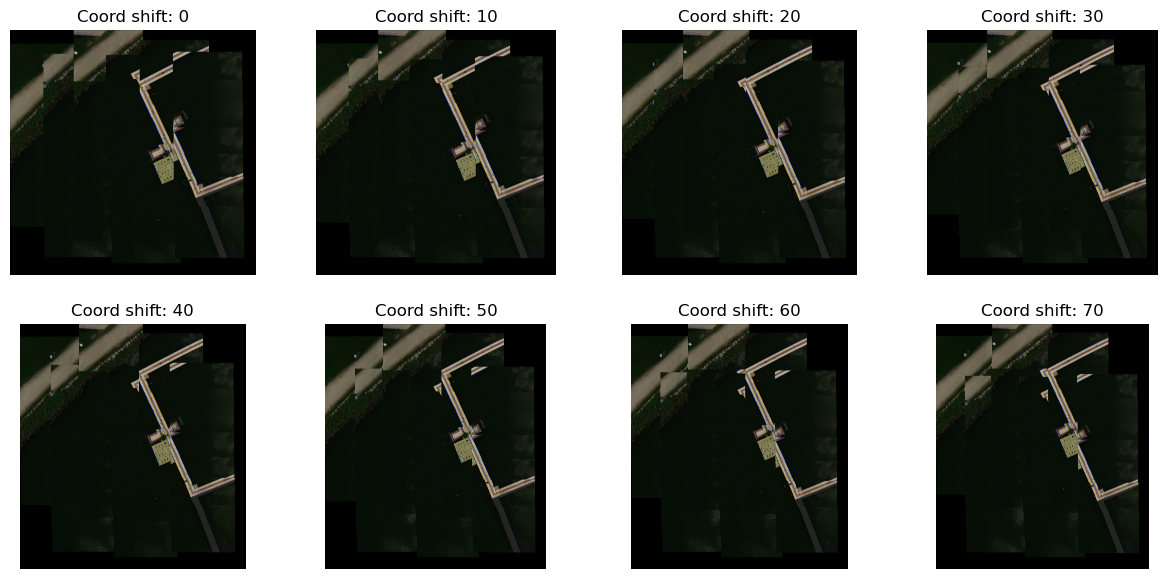

In [20]:
interpolate_distance = 0.01
pad_distance = 1.5
estimate_angle="yaw"
dist1 = 0
dist2 = 70
DEM_offset_height = 23#height_min

IC = FlightAttributes.InterpolateCoordinates(log, 
                            interpolate_distance=interpolate_distance, 
                            pad_distance=pad_distance,
                            estimate_angle=estimate_angle)
interp_dist_dict = IC.get_interpolated_dict()

n_fig = 8
fig, axes = plt.subplots(2,ceil(n_fig/2), figsize=(15,7))

dist_shift = int(pad_distance/interpolate_distance) - 1 # minus one so that we dont get indexing error

# for i, (shift_n,ax) in enumerate(zip(np.linspace(-dist_shift,dist_shift,n_fig,dtype=int),axes.flatten())):
for i, (shift_n,ax) in enumerate(zip(np.linspace(dist1,dist2,n_fig,dtype=int),axes.flatten())):
    df_interpolated = IC.shift_coord(interp_dist_dict, shift_n=shift_n)
    df_cropped = df_interpolated.iloc[flight_points,:]
    # ---- instead of using yaw, use the heading of the UAV----------
    reclassify_angles = lambda x: -180 if x < -160 else 0
    reclassified_angles = [reclassify_angles(i) for i in df_cropped['flight_angle'].to_list()]
    df_cropped['flight_angle'] = reclassified_angles
    #----------------------------------------------------------------
    for image_index, rows in df_cropped.iterrows():
        lat = rows['latitude']
        lon = rows['longitude']
        alt = rows['altitude'] - DEM_offset_height
        pitch = rows['dls-pitch']
        roll = rows['dls-roll']
        yaw = rows['dls-yaw']
        image_name = rows['image_name']
        print(f'[{image_index}] {image_name}')
        flight_angle = rows['flight_angle']
        georeferencing.directGeoreferencing_gdal(imagePath,image_name,lat,lon,alt,flight_angle,
                                                dirname=f"coordShift{shift_n}_alt{int(measuredHeight - DEM_offset_height)}")
    PG = FlightAttributes.PlotGeoreference(df_cropped,fp_list,DEM_offset_height = DEM_offset_height)
    im_display = PG.plot_georeference(reduction_factor=5,plot=False)
    ax.imshow(im_display)
    ax.axis('off')
    ax.set_title(f'Coord shift: {shift_n}')
# plt.suptitle(f'estimate angle: {estimate_angle}')
plt.show()

# Georeference corrected images

shape of canvas(5115, 4684, 3)


,timestamp,latitude,longitude,altitude,image_name,capture_id,dls-yaw,dls-pitch,dls-roll,irr-475,irr-560,irr-668,irr-842,irr-717,irr-444,irr-531,irr-650,irr-705,irr-740,flight_angle
10,2023-09-20 02:40:46.867245+00:00,1.319243,103.736855,41.484,IMG_0010_1.tif,TGMjtoMK4lZZHwz0gWE2,0.098322,-0.067554,-0.011150,0.389261,0.336241,0.263961,0.165486,0.207043,0.357777,0.352711,0.264435,0.233321,0.214836,-5.633421
11,2023-09-20 02:40:48.333197+00:00,1.319304,103.736855,41.606,IMG_0011_1.tif,Vbmk53xTHky4YeQ3tY5q,0.105641,-0.061187,-0.012180,0.388711,0.335740,0.263521,0.165222,0.206712,0.357304,0.352196,0.264010,0.232936,0.214483,-6.052807
12,2023-09-20 02:40:49.529728+00:00,1.319348,103.736855,41.475,IMG_0012_1.tif,sHfimxse9xw3yckAG5jT,0.108555,-0.092849,-0.016617,0.388261,0.335334,0.263198,0.165027,0.206479,0.356898,0.351778,0.263695,0.232662,0.214233,-6.219740
13,2023-09-20 02:40:50.856883+00:00,1.319391,103.736854,41.391,IMG_0013_1.tif,JTvwKvY3Wp1QRFABs177,0.120106,-0.088623,-0.023227,0.387690,0.334802,0.262754,0.164750,0.206159,0.356389,0.351234,0.263266,0.232289,0.213892,-6.881566
14,2023-09-20 02:40:52.169954+00:00,1.319441,103.736854,41.308,IMG_0014_1.tif,GSCS3gkaTUELPKSWJdea,0.124905,-0.094922,-0.029860,0.387213,0.334354,0.262390,0.164522,0.205883,0.355956,0.350776,0.262902,0.231979,0.213612,-7.156555


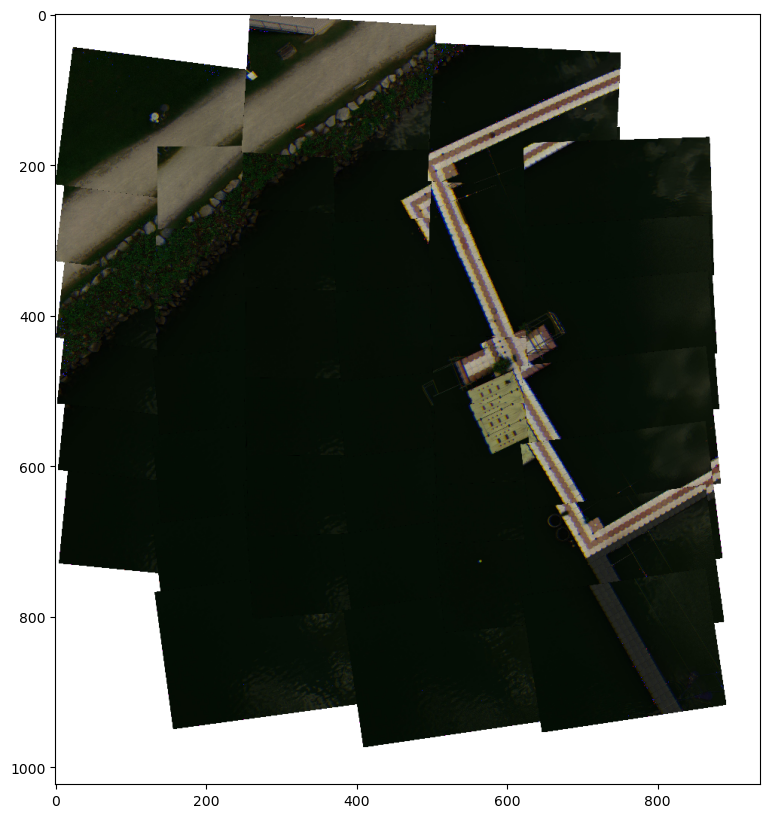

In [20]:
df_interpolated = IC.shift_coord(interp_dist_dict, shift_n=40)
df_cropped = df_interpolated.iloc[flight_points,:]
fp_list = [os.path.join(imagePath,'thumbnails',f'{os.path.splitext(fn)[0]}.jpg') for fn in df_cropped['image_name'].tolist()]
if all([os.path.exists(fp) for fp in fp_list]):
    PG = FlightAttributes.PlotGeoreference(df_cropped,fp_list,DEM_offset_height = height_min)
    im_display = PG.plot_georeference(reduction_factor=5,plot=True)
df_cropped.head()

In [15]:
for image_index in flight_points:
    lat = log['latitude'][image_index]
    lon = log['longitude'][image_index]
    alt = log['altitude'][image_index] - height_min
    pitch = log['dls-pitch'][image_index]
    roll = log['dls-roll'][image_index]
    yaw = log['dls-yaw'][image_index]
    image_name = log['image_name'][image_index]
    print(f'[{image_index}] {image_name}')
    flight_angle = -yaw/np.pi*180 # measured wrt North
    georeferencing.directGeoreferencing_gdal(imagePath,image_name,lat,lon,alt,flight_angle,
                                             dirname=f"coordShift_alt{int(measuredHeight - height_min)}")

[10] IMG_0010_1.tif
[11] IMG_0011_1.tif
[12] IMG_0012_1.tif
[13] IMG_0013_1.tif
[14] IMG_0014_1.tif
[15] IMG_0015_1.tif
[19] IMG_0019_1.tif
[20] IMG_0020_1.tif
[21] IMG_0021_1.tif
[22] IMG_0022_1.tif
[23] IMG_0023_1.tif
[24] IMG_0024_1.tif
[25] IMG_0025_1.tif
[29] IMG_0029_1.tif
[30] IMG_0030_1.tif
[31] IMG_0031_1.tif
[32] IMG_0032_1.tif
[33] IMG_0033_1.tif
[34] IMG_0034_1.tif
[35] IMG_0035_1.tif
[39] IMG_0039_1.tif
[40] IMG_0040_1.tif
[41] IMG_0041_1.tif
[42] IMG_0042_1.tif
[43] IMG_0043_1.tif
[44] IMG_0044_1.tif
[45] IMG_0045_1.tif
[49] IMG_0049_1.tif
[50] IMG_0050_1.tif
[51] IMG_0051_1.tif
[52] IMG_0052_1.tif
[53] IMG_0053_1.tif
[54] IMG_0054_1.tif
[55] IMG_0055_1.tif
[59] IMG_0059_1.tif
[60] IMG_0060_1.tif
[61] IMG_0061_1.tif
[62] IMG_0062_1.tif
[63] IMG_0063_1.tif
[64] IMG_0064_1.tif
[65] IMG_0065_1.tif
